In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import itertools
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm


warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
warnings.simplefilter("ignore", category=UserWarning)

<h1>Load Data</h1>
<h3>Note: loaded data is filtered to only include extreme negative values from one of the intraday percent change columns. </h3>
<h3>Exact criteria is given in below (screen_conditions.ipynb). Data just needs to meet one of these conditions, not all of them. </h3>
<h3>This comes from previous research where we found that extreme negative moves heading into market close lad to positive afterhours returns. View the end of exploration.ipynb for some of that research. </h3>

In [4]:
df = pd.read_csv('main.csv')
df = df[df['%c120m'] < 5]
pct_feats = [col for col in df.columns if '%' in col and 'lag' not in col and 'screen' not in col]
for col in pct_feats:
    df[col] = df[col] * 100
lag_feats = [col for col in df.columns if 'lag' in col]
screen = [col for col in df.columns if 'screen' in col]
dollar_volumes = [col for col in df.columns if 'dv' in col]
returns = ['vwap_return', 'vwap_ft_return', 'ask_bid_return', 'mid_return','vwap_sfill_return']
for col in returns:
    df[col] = df[col] * 100
entry_desc = ['first_tick_time','close_quote_time','open_quote_time']
intra = [col for col in df.columns if 'pc' in col]
for col in dollar_volumes:
    # Create new columns with the log-transformed values
    df[f'log_{col}'] = np.log(df[col] + 1e-10)
dv_logs = [col for col in df.columns if 'log' in col]

<h1>Regression function</h1>

In [5]:
def regression(x,y,mode):
    #fit model
    if isinstance(x, str):
        regdf = df[[x,y,'date']].dropna()
        X = regdf[x]
        Y = regdf[y]
    elif isinstance(x, list):
        regdf = df[x + [y] + ['date']].dropna()
    X = sm.add_constant(regdf[x])
    Y = regdf[y]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
    model = sm.OLS(Y_train,X_train).fit()
    train = pd.concat([X_train,Y_train],axis=1)
    train['pred'] = model.predict(X_train)
    train['resid'] = model.resid
    #---------Selection Mode----------#
    if mode == 'select':
        mae = mean_absolute_error(train['vwap_sfill_return'],train['pred'])
        return mae
    elif mode == 'analyze':
        print(model.summary())  
        print(f"MAE: {mean_absolute_error(train['vwap_sfill_return'],train['pred'])}")
        plt.scatter(train['pred'],train['resid'],s=4)
        plt.xlim(-10,10)
        plt.ylim(-100,200)
        plt.xlabel('predicted values')
        plt.ylabel('residuals')
        plt.show()
    elif mode == 'extract':
        test = pd.concat([X_test,Y_test],axis=1)
        test['pred'] = model.predict(X_test)
        return train,test

<h1>Select features</h1>
<h3>Add features to OLS regression 1 at a time, add feature that has greatest improvement on mean absolute error</h3>
<h3>Stop when mean absolute error cannot be improved</h3>

In [6]:
#Initialize variables
start_mae = np.inf
all_feats = pct_feats + lag_feats
use_feats = []
#First loop: evaluate each feature individually
for col in all_feats:
    new_mae = regression([col], 'vwap_sfill_return','select')  #Assuming 'regression' accepts a list of features
    if new_mae < start_mae:
        use_feats = [col]  #Reset use_feats with the current best feature
        start_mae = new_mae  #Update start_mae to the best MAE
#Second loop: add features only if they improve MAE
complete = False
while not complete:
    best_improvement = None  #Variable to track best improvement
    best_feature = None  #Variable to track the feature with the best improvement
    for col in [col for col in all_feats if col not in use_feats]:
        new_mae = regression(use_feats + [col], 'vwap_sfill_return', 'select')
        #Track the feature that results in the lowest MAE
        if new_mae < start_mae:
            best_improvement = new_mae
            best_feature = col
    if best_feature:  #If a feature improved the MAE
        use_feats.append(best_feature)
        start_mae = best_improvement  #Update the MAE to the new best value
    else:
        complete = True  #Stop if no feature improved the MAE
#After the loop ends, `use_feats` contains the selected features
print("Selected features:", use_feats)

Selected features: ['%c90m', '%c3d', '%c2d', '%cpah', '%c360m', '%c1d', '%c120m', '%c2m']


<h1>Test selection output</h1>
<h3>Removed 3-day percentage change due to low t-stat, improved MAE by 0.0007</h3>


                            OLS Regression Results                            
Dep. Variable:      vwap_sfill_return   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 06 Dec 2024   Prob (F-statistic):          1.69e-158
Time:                        00:05:00   Log-Likelihood:            -3.3057e+05
No. Observations:               92560   AIC:                         6.612e+05
Df Residuals:                   92552   BIC:                         6.612e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4024      0.032     12.684      0.0

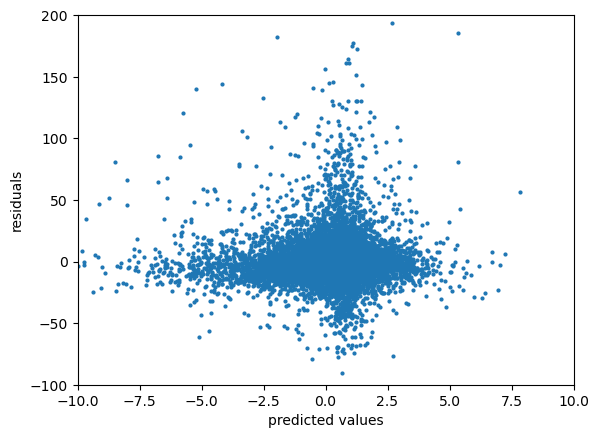

In [7]:
regression(['%c90m','%c2d', '%cpah', '%c360m', '%c1d', '%c120m', '%c2m'],'vwap_sfill_return','analyze')

<h1>Test in and out of sample performance</h1>

In [8]:
insample, outsample = regression(['%c90m','%c2d', '%cpah', '%c360m', '%c1d', '%c120m', '%c2m'],'vwap_sfill_return','extract')
insample[['ticker','date']] = df.loc[insample.index][['ticker', 'date']]
insample = insample.sort_values(by='date')
outsample[['ticker','date']] = df.loc[outsample.index][['ticker', 'date']]
outsample = outsample.sort_values(by='date')

<h1>Look at mean and std based on predicted return bins</h1>

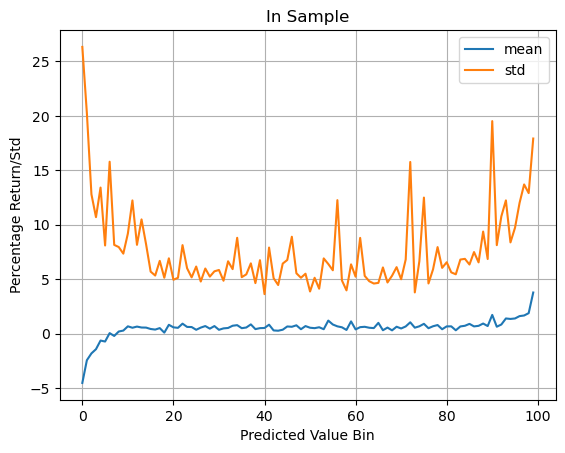

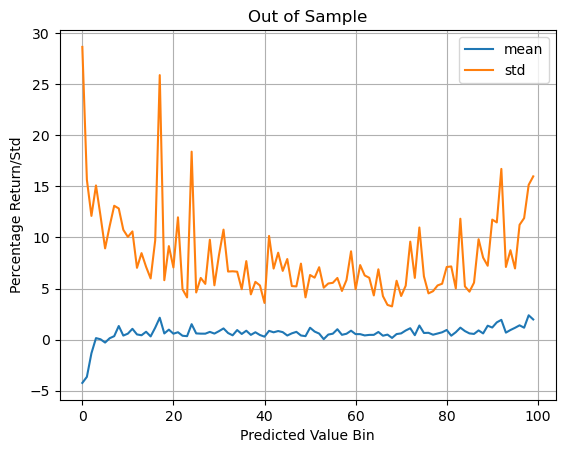

In [9]:
insample['predbin'] = pd.qcut(insample['pred'],q=100)
plotin = insample.groupby('predbin')['vwap_sfill_return'].agg(['mean','std','count']).reset_index()
plt.plot(plotin.index,plotin['mean'],label='mean')
plt.plot(plotin.index,plotin['std'],label='std')
plt.legend()
plt.grid()
plt.title('In Sample')
plt.xlabel('Predicted Value Bin')
plt.ylabel('Percentage Return/Std')
plt.show()
outsample['predbin'] = pd.qcut(outsample['pred'],q=100)
plotout = outsample.groupby('predbin')['vwap_sfill_return'].agg(['mean','std','count']).reset_index()
plt.plot(plotout.index,plotout['mean'],label='mean')
plt.plot(plotout.index,plotout['std'],label='std')
plt.legend()
plt.grid()
plt.title('Out of Sample')
plt.xlabel('Predicted Value Bin')
plt.ylabel('Percentage Return/Std')
plt.show()

<h1>Choose best predicted value based on maximizing daily Sharpe</h1>
<h3>@Kash - this is where we can likely improve by assinging portfolio weights based on projected mean/variance from predicted values</h3>

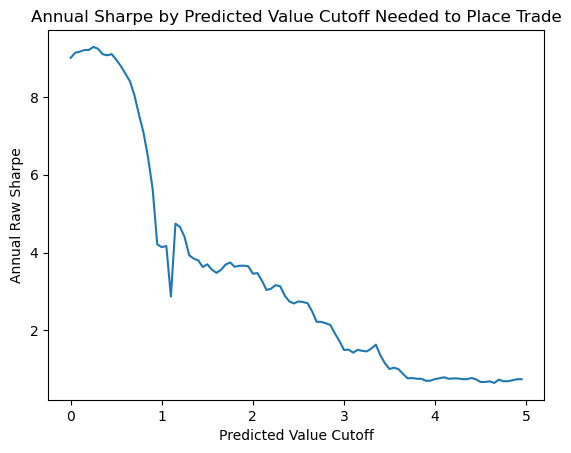

In [10]:
df_lists = []
for x in np.arange(0,5,.05):
    intrades = insample[insample['pred'] > x] #Set minimum predicted value for trade
    in_daily = intrades.groupby('date')['vwap_sfill_return'].mean() #Assumes equal weight in each trade
    in_daily = pd.DataFrame(in_daily.reindex(insample['date'].unique(), fill_value=0)).sort_values(by='date') #fill dates where didnt trade with 0
    mean,std = in_daily['vwap_sfill_return'].agg(['mean','std']) #get daily mean,std,count
    df_lists.append([x,mean,std,len(intrades)/len(insample['date'].unique())]) #append mean, std, and trades per day 
in_results = pd.DataFrame(df_lists,columns=['pred_cutoff','mean_daily','std_daily','trades/day'])
in_results['annual_return'] = in_results['mean_daily'] * 252    #annual return
in_results['annual_std'] = in_results['std_daily'] * np.sqrt(252)   #annual std
in_results['annual_sharpe_raw'] = in_results['annual_return'] / in_results['annual_std']    #annual raw sharpe
plt.xlabel('Predicted Value Cutoff')
plt.ylabel('Annual Raw Sharpe')
plt.title('Annual Sharpe by Predicted Value Cutoff Needed to Place Trade')
plt.plot(in_results['pred_cutoff'],in_results['annual_sharpe_raw'])
plt.show()

<h1>Cannot select values below 0.1 cutoff, because it requires placing too many trades in a minute to be profitable</h1>
<h3>Assuming maximum trades we can place in a minute is ~20</h3>
<h1>Select 1.15 as minimum predicted value to place trade -> Get out of sample results</h1>

In [11]:
df_lists = []
for x in np.arange(0, 5, 0.05):
    outtrades = outsample[outsample['pred'] > x]
    out_daily = outtrades.groupby('date')['vwap_sfill_return'].mean()
    out_daily = pd.DataFrame(out_daily.reindex(outsample['date'].unique(), fill_value=0)).sort_values(by='date')
    mean, std = out_daily['vwap_sfill_return'].agg(['mean', 'std'])
    df_lists.append([x, mean, std, len(outtrades) / len(outsample['date'].unique())])
out_results = pd.DataFrame(df_lists, columns=['pred_cutoff', 'mean_daily', 'std_daily', 'trades/day'])
out_results['annual_return'] = out_results['mean_daily'] * 252
out_results['annual_std'] = out_results['std_daily'] * np.sqrt(252)
out_results['annual_sharpe_raw'] = out_results['annual_return'] / out_results['annual_std']
out_results[out_results['pred_cutoff'] == 1.1500000000000001] #annoying np.arange thing

,pred_cutoff,mean_daily,std_daily,trades/day,annual_return,annual_std,annual_sharpe_raw
23,1.15,1.352818,5.960086,5.684492,340.910128,94.613427,3.60319


<h1>Annual return will be much lower in practice</h1>